In [1]:
%pylab inline
import os,sys,pickle
from scipy.stats import percentileofscore, chi2
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d
from scipy.special import gamma as gamma_fn
from scipy.optimize import minimize

Populating the interactive namespace from numpy and matplotlib


# Odd-Parity BOSS 4PCF Analysis
This notebook contains the main analysis routines used in Philcox (2021) to probe parity-violation in the BOSS 4-point correlation functions. Note that this notebook was constructed without access to the data, *i.e.* the analysis was blind.

In [2]:
# Data directories
indirN = '/projects/QUIJOTE/Oliver/npcf/boss_4pcfNall_production/'
indirS = '/projects/QUIJOTE/Oliver/npcf/boss_4pcfSall_production/'

plot_dir = '/home/ophilcox/Parity-Odd-4PCF/figs/'

# Binning parameters
R_min = 20
R_max = 160
n_r = 10

# If False, turn off blinding
fake_data = True

# 1) Load 4PCFs
- These are computed with the [*encore*](https://github.com/oliverphilcox/encore) code of [Philcox et al. 2021](https://arxiv.org/abs/2105.08722)
- We use 10 linearly-space radial bins in the range [20, 160] $h^{-1}\mathrm{Mpc}$
- All multiplets (of odd- and even-parity) are computed up to $\ell_\mathrm{max} = 5$, with $\ell=5$ multiplets only being used for edge-correction.
- Here we consider only bins with $\ell_i\leq 4$, and ensure that all bin centers are separated by at least $\Delta r$ to avoid any vanishingly small separations.
- We analyze both the BOSS data, in the CMASS NGC and SGC regions, as well as 250 MultiDark-Patchy mocks.

In [3]:
binner = lambda bins: (0.5+bins)*(R_max-R_min)/n_r+R_min

def load_patchy(indir,return_all=False):
    """Load 4PCFs from Patchy"""
    all_fourpcf = []
    for sim_no in range(1,251):
        infile = indir+'patchy%d_cmass.zeta_4pcf.txt'%sim_no
        if not os.path.exists(infile): continue
        bins1,bins2,bins3 = np.asarray(np.loadtxt(infile,skiprows=3,max_rows=3),dtype=int)
        ell1,ell2,ell3 = np.asarray(np.loadtxt(infile,skiprows=9)[:,:3],dtype=int).T
        indat = np.loadtxt(infile,skiprows=9)[:,3:]
        all_fourpcf.append(indat)
        if sim_no==1:
            r1_4pcf = binner(bins1)
            r2_4pcf = binner(bins2)
            r3_4pcf = binner(bins3)  
    if return_all:
        return [r1_4pcf,r2_4pcf,r3_4pcf],[bins1,bins2,bins3],[ell1,ell2,ell3],all_fourpcf
    else:
        return all_fourpcf
    
def load_boss(indir):
    """Load 4PCFs from BOSS"""
    infile = indir+'boss_cmass.zeta_4pcf.txt'
    indat = np.loadtxt(infile,skiprows=9)[:,3:]
    fourpcf_boss = indat
    return fourpcf_boss

# Load Patchy data
radii, bins, ells, fourpcfN = load_patchy(indirN,return_all=True)
fourpcfS = load_patchy(indirS)
    
n_radial = len(bins[0])
n_mult = len(ells[0])

# Load BOSS data
if fake_data:
    print("Replacing BOSS data with first Patchy mock")
    fourpcf_bossN = fourpcfN[0]
    fourpcf_bossS = fourpcfS[0]
    fourpcfN = fourpcfN[1:]
    fourpcfS = fourpcfS[1:]
else:
    fourpcf_bossN = load_boss(indirN)
    fourpcf_bossS = load_boss(indirS)
    
n_mocks = len(fourpcfN)
assert n_mocks == len(fourpcfS)

print("N_mocks: %d"%n_mocks)
print("N_mult: %d"%n_mult)
print("N_radial: %d"%n_radial)

Replacing BOSS data with first Patchy mock
N_mocks: 249
N_mult: 111
N_radial: 120


# 2) Apply Data Cuts

- Apply the cuts described above for the radial and angular bins, including removing any parity-even multiplets.

In [4]:
# filter out ells which are not properly edge-corrected
LMAX=4
ang_filt = np.asarray(np.logical_and(np.logical_and(ells[0]<=LMAX,ells[1]<=LMAX),ells[2]<=LMAX))

# remove any even multipoles
ang_filt = ang_filt*((-1.)**(ells[0]+ells[1]+ells[2])==-1.)

# remove any bins within 20Mpc of each other
dr = (R_max-R_min)/n_r
radial_filt = ((radii[1]-radii[0])>1.9*n_r)&((radii[2]-radii[1])>1.9*n_r)

# Apply filters
filt_fourpcfN = np.asarray([ff[ang_filt][:,radial_filt] for ff in fourpcfN])
filt_fourpcfS = np.asarray([ff[ang_filt][:,radial_filt] for ff in fourpcfS])
filt_fourpcf_bossN = fourpcf_bossN[ang_filt][:,radial_filt]
filt_fourpcf_bossS = fourpcf_bossS[ang_filt][:,radial_filt]
filt_flat_fourpcfN = np.asarray([ff.ravel() for ff in filt_fourpcfN])
filt_flat_fourpcfS = np.asarray([ff.ravel() for ff in filt_fourpcfS])
filt_flat_fourpcf_bossN = filt_fourpcf_bossN.ravel()
filt_flat_fourpcf_bossS = filt_fourpcf_bossS.ravel()

# Redefine array dimensions
n_radial = np.sum(radial_filt)
n_mult = np.sum(ang_filt)

print("N_Lambda: %d"%n_mult)
print("N_bins: %d"%n_radial)
print("N_total: %d"%(n_mult*n_radial))

N_Lambda: 23
N_bins: 56
N_total: 1288


# 3) Plot Correlation and Covariance Matrices
- Theory covariances are computed in the Gaussian Random Field approximation as in Hou et al. (in prep.).
- Note that they do not include redshift-space distortions, non-Gaussian contributions, or a proper treatment of the survey geometry.
- For this reason they are used only as approximate tools for the non-parametric and compressed-Gaussian analyses below (except in Sec. 5a); importantly, we do *not* assume them to be equal to the true covariance of the data.

In [5]:
### Compute Patchy covariances
corrN = np.corrcoef(filt_flat_fourpcfN.T)
covN = np.cov(filt_flat_fourpcfN.T)
corrS = np.corrcoef(filt_flat_fourpcfS.T)
covS = np.cov(filt_flat_fourpcfS.T)

### Load theory covariances
def load_theory_cov(patch):
    cov_file = '/projects/QUIJOTE/Oliver/npcf/gaussian_cov/4pcf_patchy_%s_odd_z0d57_connected_all.cov.py2'%patch
    cov_dat = pickle.load(open(cov_file, "rb"))

    # Construct covariance
    theory_cov = np.zeros((n_mult*n_radial,n_mult*n_radial))
    for i in range(n_mult):
        lam1 = '%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i])
        for j in range(n_mult):
            lam2 = '%d%d%d'%(ells[0][ang_filt][j],ells[1][ang_filt][j],ells[2][ang_filt][j])
            try: 
                this_cov = cov_dat[lam1,lam2]
            except KeyError:
                this_cov = cov_dat[lam2,lam1].T
            theory_cov[i*n_radial:(i+1)*n_radial,j*n_radial:(j+1)*n_radial] = this_cov[radial_filt][:,radial_filt]
    return theory_cov

theory_covN = load_theory_cov('ngc')
theory_covS = load_theory_cov('sgc')

theory_corrN = theory_covN/np.sqrt(np.outer(np.diag(theory_covN),np.diag(theory_covN)))
theory_corrS = theory_covS/np.sqrt(np.outer(np.diag(theory_covS),np.diag(theory_covS)))

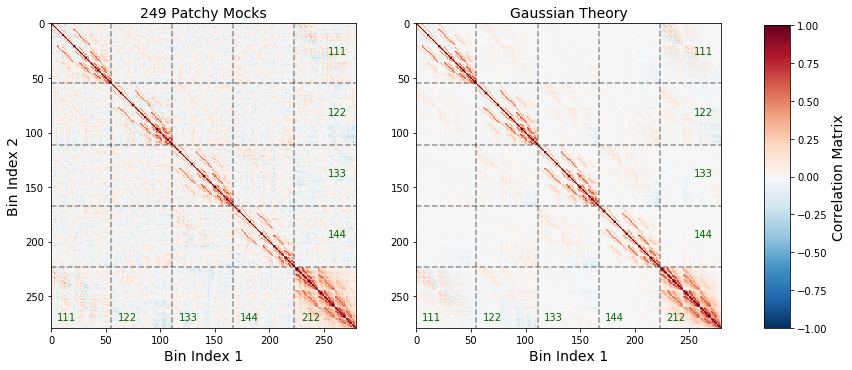

In [6]:
n_max = 5
fig,ax = plt.subplots(1,2,figsize=(12,6))
im = ax[0].imshow(corrN[:n_max*n_radial,:n_max*n_radial],vmax=1,vmin=-1,cmap=cm.RdBu_r);
im = ax[1].imshow(theory_corrN[:n_max*n_radial,:n_max*n_radial],vmax=1,vmin=-1,cmap=cm.RdBu_r);
#im.colorbar();
for i in range(n_max):
    for a in range(2):
        if i!=0: ax[a].hlines(n_radial*i-1,0,n_max*n_radial,linestyles='--',alpha=0.4)
        if i!=0: ax[a].vlines(n_radial*i-1,0,n_max*n_radial,linestyles='--',alpha=0.4)
        if i!=n_max-1: ax[a].text(n_radial*(n_max-1)+n_radial/10+25,n_radial*i+n_radial/2,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10)
        ax[a].text(n_radial*i+n_radial/10,n_radial*(n_max-1)+n_radial/2+20,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10)
for a in range(2):
    ax[a].set_xlim([0,n_radial*n_max-1])
    ax[a].set_ylim([n_radial*n_max-1,0])
ax[0].set_title('%d Patchy Mocks'%n_mocks,fontsize=14)
ax[1].set_title('Gaussian Theory',fontsize=14);
for a in range(2): ax[a].set_xlabel(r'Bin Index 1',fontsize=14)
ax[0].set_ylabel(r'Bin Index 2',fontsize=14)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Correlation Matrix',fontsize=14)

fig.savefig(plot_dir+'correlation_comparison_ngc.pdf',bbox_inches='tight')

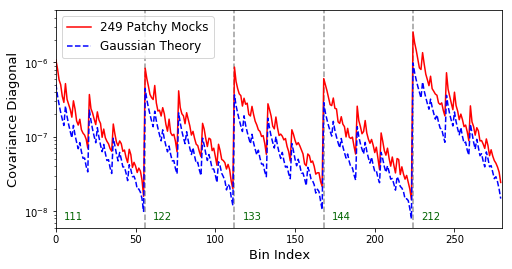

In [7]:
plt.figure(figsize=(8,4))
n_max = 5
plt.plot(np.diag(covN)[:n_max*n_radial],c='r',ls='-',label='%d Patchy Mocks'%n_mocks)
plt.plot(np.diag(theory_covN)[:n_max*n_radial],c='b',ls='--',label='Gaussian Theory')
plt.yscale('log')
plt.xlim([0,n_max*n_radial])
ylims = [6e-9,5e-6]
plt.ylim(ylims)
for i in range(n_max):
    if i!=0: plt.vlines(n_radial*i,ylims[0],ylims[1],linestyles='--',alpha=0.4)
    plt.text(n_radial*i+n_radial/10,ylims[0]*1.3,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10) 
plt.legend(loc='upper left',fontsize=12)
plt.xlabel(r'Bin Index',fontsize=13)
plt.ylabel(r'Covariance Diagonal',fontsize=13)

plt.savefig(plot_dir+'variance_comparison_ngc.pdf',bbox_inches='tight')

In [8]:
print("SGC covariance is inflated relative to NGC by a factor of %.2f"%(np.mean(theory_covS/theory_covN)))

SGC covariance is inflated relative to NGC by a factor of 2.49


# 4) Plot Data
- We plot a selection of 4PCF multiplets below, since the total number is large. The eventual analysis makes use of all odd-parity multiplets given the above restrictions.

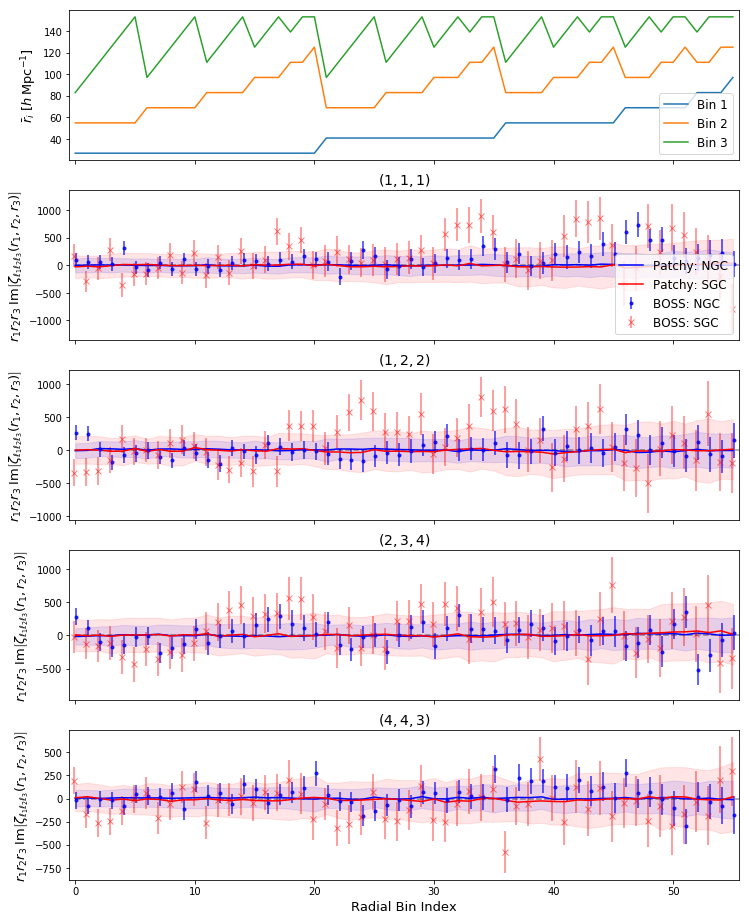

In [9]:
xmax = n_radial-1
r123 = (radii[0]*radii[1]*radii[2])[radial_filt]

which_indices = [0,1,8,22]
n_plots = len(which_indices)

fig,ax = plt.subplots(n_plots+1,figsize=(12,4*n_plots),sharex=True)
ax[0].plot(np.arange(n_radial),radii[0][radial_filt],label='Bin 1')
ax[0].plot(np.arange(n_radial),radii[1][radial_filt],label='Bin 2')
ax[0].plot(np.arange(n_radial),radii[2][radial_filt],label='Bin 3')
ax[0].set_xlim([-0.5,xmax+0.5])
ax[0].set_ylabel(r'$\bar r_i$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=13)
ax[0].legend(loc='lower right',fontsize=12)

fourpcfN_mean = np.mean(filt_fourpcfN,axis=0)
fourpcfN_std = np.std(filt_fourpcfN,axis=0)
fourpcfS_mean = np.mean(filt_fourpcfS,axis=0)
fourpcfS_std = np.std(filt_fourpcfS,axis=0)

for ii,i in enumerate(which_indices):
    
    # Plot Patchy data
    ax[ii+1].fill_between(np.arange(n_radial),r123*(fourpcfN_mean[i]-fourpcfN_std[i]),
                     r123*(fourpcfN_mean[i]+fourpcfN_std[i]),color='b',alpha=0.1)
    ax[ii+1].plot(np.arange(n_radial),r123*fourpcfN_mean[i],label=r'Patchy: NGC',c='b')

    ax[ii+1].fill_between(np.arange(n_radial),r123*(fourpcfS_mean[i]-fourpcfS_std[i]),
                     r123*(fourpcfS_mean[i]+fourpcfS_std[i]),color='r',alpha=0.1)
    ax[ii+1].plot(np.arange(n_radial),r123*fourpcfS_mean[i],label=r'Patchy: SGC',c='r')
        
    # Plot BOSS data
    ax[ii+1].errorbar(np.arange(n_radial)+0.1,r123*filt_fourpcf_bossN[i],yerr=r123*fourpcfN_std[i],
                     ls='',c='b',marker='.',label=r'BOSS: NGC',alpha=0.8)
    ax[ii+1].errorbar(np.arange(n_radial)-0.1,r123*filt_fourpcf_bossS[i],yerr=r123*fourpcfS_std[i],
                     ls='',c='r',marker='x',label=r'BOSS: SGC',alpha=0.5)

    ax[ii+1].hlines(0,0,n_radial,linestyles='--',color='k',alpha=0.4)
    
    if ii==0: ax[ii+1].legend(loc='lower right',fontsize=12)
    ax[ii+1].set_ylabel(r'$r_1r_2r_3\;\mathrm{Im}\left[\zeta_{\ell_1\ell_2\ell_3}(r_1,r_2,r_3)\right]$',fontsize=13)
    ax[ii+1].set_title(r'$(%d,%d,%d)$'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),fontsize=14);

ax[n_plots].set_xlabel(r'Radial Bin Index',fontsize=13)
fig.savefig(plot_dir+'4pcf_main_plot.pdf',bbox_inches='tight')

# 5) Perform a non-parametric rank test
- First define the *pseudo*-$\chi^2$ statistic $S = [d^T \tilde{\mathsf C}^{-1} d]_\mathrm{NGC}+[d^T \tilde{\mathsf C}^{-1} d]_\mathrm{SGC}$ for theory covariance $\tilde{\mathsf{C}}$.
- Plot the distribution of $S$ from the Patchy mocks, and add the data.
- The rank of the true data gives the significance of the detection.
- Note thiat this avoids (a) assuming that the theory covariance matches the true covariance and (b) that the data is Gaussian.

In [10]:
# Invert the theory covariance
inv_theory_covN = np.linalg.inv(theory_covN)
inv_theory_covS = np.linalg.inv(theory_covS)

def pseudo_chi2(dataN, dataS):
    """Define the pseudo-chi^2 statistic from NGC and SGC 4PCF data."""
    theoryN = np.zeros_like(dataN)
    theoryS = np.zeros_like(dataS)
    xN = np.inner(dataN-theoryN, np.inner(inv_theory_covN, dataN-theoryN))
    xS = np.inner(dataS-theoryS, np.inner(inv_theory_covS, dataS-theoryS))
    return xN + xS

pseudo_chi2_patchy = np.asarray([pseudo_chi2(filt_flat_fourpcfN[i], filt_flat_fourpcfS[i]) for i in range(n_mocks)])
pseudo_chi2_boss = pseudo_chi2(filt_flat_fourpcf_bossN,filt_flat_fourpcf_bossS)

boss_percentile = percentileofscore(pseudo_chi2_patchy,pseudo_chi2_boss)

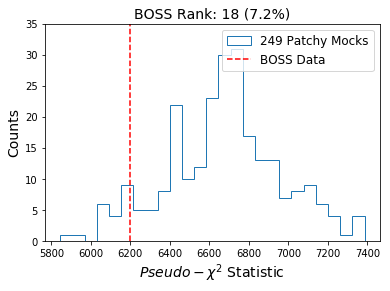

In [11]:
plt.figure(figsize=(6,4))
ct,x,_=plt.hist(pseudo_chi2_patchy,bins=25,label='%d Patchy Mocks'%n_mocks,histtype='step');
plt.vlines(pseudo_chi2_boss,0,max(ct)+10,linestyles='--',color='r',label='BOSS Data')
plt.ylim(0,max(ct)+4)
plt.xlabel(r'${Pseudo}-\chi^2$ Statistic',fontsize=14);
plt.ylabel(r'Counts',fontsize=14)
plt.title(r'BOSS Rank: %d (%.1f%%)'%(boss_percentile*n_mocks/100.,boss_percentile),fontsize=14)
plt.legend(fontsize=12)
plt.savefig(plot_dir+'non-parametric-plot.pdf',bbox_inches='tight')

## 5a) Analyze with Rescaled Theory Covariance
- We may approximate the Gaussian covariance matrix as the theory covariance matrix with some rescaling factor (principally to act as an effective volume).
- We fit for the effective volume with the Kullback-Leibler divergence, comparing the true and theory covariances.
- This can be used to create a smooth $\chi^2$ for the data, which is compared to the usual distribution.
- Note that this is not a robust statistic, since it assumes that the theory covariance is only wrong by a constant factor, and that the data is Gaussian.
- For this reason, we find the PDF of the mock data to not quite match the $\chi^2$ distribution expected.
- The associated results should be taken with a pinch of salt for this reason.

Optimal Rescaling: 2.59x


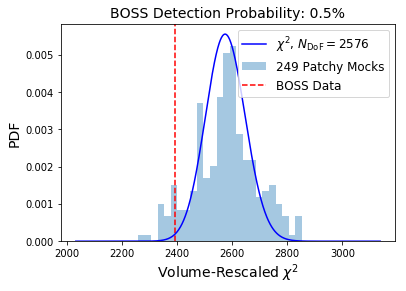

In [12]:
### First, stack the N and S data (with independent covariances)
stack_fourpcf = np.hstack([filt_flat_fourpcfN,filt_flat_fourpcfS])
stack_fourpcf_mean = np.mean(stack_fourpcf,axis=0)
stack_fourpcf_boss = np.hstack([filt_flat_fourpcf_bossN,filt_flat_fourpcf_bossS])

stack_theory_cov = np.zeros((n_mult*n_radial*2,n_mult*n_radial*2))
stack_theory_cov[:n_mult*n_radial,:n_mult*n_radial] = theory_covN
stack_theory_cov[n_mult*n_radial:,n_mult*n_radial:] = theory_covS

# Define a combined covariance matrix
inv_stack_theory_cov = np.linalg.inv(stack_theory_cov)
stack_cov = np.cov(stack_fourpcf.T)

# Compute an optimal rescaling factor
trace_disc_0 = np.trace(np.matmul(inv_stack_theory_cov,stack_cov))
logdet0 = np.linalg.slogdet(inv_stack_theory_cov)[1]
def KL_div(rescaling):
    """Use the Kullback-Leibler divergence to give the log-likelihood for the rescaling."""
    return trace_disc_0/rescaling-(logdet0-np.log(rescaling)*len(stack_theory_cov))

opt_rescaling = minimize(KL_div,1.).x
print("Optimal Rescaling: %.2fx"%opt_rescaling)

# Rescale theory matrix
opt_theory_cov = stack_theory_cov*opt_rescaling
inv_opt_theory_cov = inv_stack_theory_cov/opt_rescaling

theory_model = np.zeros_like(stack_fourpcf_boss)
opt_chi2 = np.asarray([np.inner(dd-theory_model,np.inner(inv_opt_theory_cov,dd-theory_model)) for dd in stack_fourpcf])
opt_chi2_boss = np.inner(stack_fourpcf_boss-theory_model,np.inner(inv_opt_theory_cov,stack_fourpcf_boss-theory_model))

bins = 25
plt.figure()
ct,x,_=plt.hist(opt_chi2,bins=bins,alpha=0.4,density=1,label=r'%d Patchy Mocks'%n_mocks)
x_arr = np.arange(min(x)*0.9,max(x)*1.1)
p = len(stack_fourpcf_boss)
chi2_pdf = chi2.pdf(x_arr,p)
boss_prob = chi2.cdf(opt_chi2_boss,p)
plt.title(r'BOSS Detection Probability: %.1f%%'%(100.*boss_prob),fontsize=14)
plt.plot(x_arr,chi2_pdf,color='blue',label=r'$\chi^2$, $N_\mathrm{DoF} = %d$'%p)
plt.vlines(opt_chi2_boss,0,2*max(ct),color='red',linestyles='--',label='BOSS Data')
plt.legend(fontsize=12);
plt.ylim([0,max([max(ct),max(chi2_pdf)])*1.05])
plt.xlabel(r'Volume-Rescaled $\chi^2$',fontsize=14)
plt.ylabel(r'PDF',fontsize=14)
plt.savefig(plot_dir+'vol_rescaled_chi2.pdf',bbox_inches='tight')

# 6) Perform data compression

- We project the data onto the eigenvectors of the *model* inverse covariance matrix.
- This would be an optimal projection if true = model covariance, in the Gaussian limit.
- Here, $v = U^T\zeta$ where $\tilde{\mathsf C} = U\Lambda U^T$, and we keep the first $N_\mathrm{eig}$ eigenvectors, which are ordered in inverse variance, i.e. we use those with the smallest $\Lambda$.
- The covariance matrix of $v$ is *close* to diagonal, with $\langle vv^T \rangle = U^TC_DU$. If $C_D = \tilde{\mathsf{C}} = U\Lambda U^T$, then $\langle vv^T \rangle = \Lambda$, which is diagonal.

- This is performed for NGC and SGC independently, since they are assumed to be independent.

In [13]:
### Define the eigenvectors from the inverse theory covariance
evalsN,evecsN = np.linalg.eigh(inv_theory_covN)
evalsS,evecsS = np.linalg.eigh(inv_theory_covS)
evalsN = evalsN[::-1]
evecsN = evecsN[:,::-1]
evalsS = evalsS[::-1]
evecsS = evecsS[:,::-1]

In [14]:
### Now project data
fourpcf_meanN = np.mean(filt_flat_fourpcfN,axis=0)
fourpcf_meanS = np.mean(filt_flat_fourpcfN,axis=0)

def project_data(data,N_eig,patch='ngc'):
    """Project data onto the eigenvector basis for NGC or SGC. 
    Note that the mean vector cancels in all chi^2-type analyses, but is included by convention."""
    if patch=='ngc':
        these_evecs = evecsN[:,:N_eig]
        mean = fourpcf_meanN
    else:
        these_evecs = evecsS[:,:N_eig]
        mean = fourpcf_meanS
    proj_data = np.matmul(these_evecs.T,(data-mean).T).T
    return proj_data

def deproject_data(projected_data,N_eig,patch='ngc'):
    """Deproject data out of the eigenvector basis."""
    if patch=='ngc':
        these_evecs = evecsN[:,:N_eig]
        mean = fourpcf_meanN
    else:
        these_evecs = evecsS[:,:N_eig]
        mean = fourpcf_meanS
    deproj_data = mean + np.matmul(these_evecs,projected_data.T).T
    return deproj_data

N_eig = 50
projected_fourpcfN = project_data(filt_flat_fourpcfN,N_eig,'ngc')
projected_fourpcfS = project_data(filt_flat_fourpcfS,N_eig,'sgc')
projected_fourpcf_bossN = project_data(filt_flat_fourpcf_bossN,N_eig,'ngc')
projected_fourpcf_bossS = project_data(filt_flat_fourpcf_bossS,N_eig,'sgc')

projected_theoryN = project_data(np.zeros_like(filt_flat_fourpcf_bossN),N_eig,'ngc')
projected_theoryS = project_data(np.zeros_like(filt_flat_fourpcf_bossS),N_eig,'sgc')

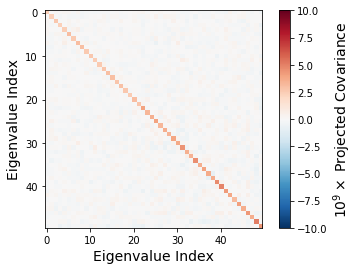

In [15]:
plt.imshow(1e9*np.cov(projected_fourpcfN.T),cmap=cm.RdBu_r,vmax=10,vmin=-10);
fs = 14
cbar = plt.colorbar();
plt.xlabel(r'Eigenvalue Index',fontsize=fs)
plt.ylabel(r'Eigenvalue Index',fontsize=fs)
cbar.set_label(r'$10^9 \times$ Projected Covariance',fontsize=fs)
plt.savefig(plot_dir+'projected_4pcf_covN.pdf',bbox_inches='tight')

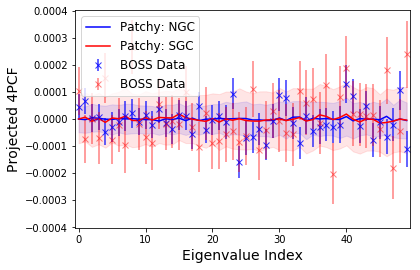

In [16]:
meanN = projected_fourpcfN.mean(axis=0)-projected_theoryN
stdN = projected_fourpcfN.std(axis=0)
meanS = projected_fourpcfS.mean(axis=0)-projected_theoryS
stdS = projected_fourpcfS.std(axis=0)
i_arr = np.arange(len(meanN))
plt.errorbar(i_arr,meanN,label='Patchy: NGC',c='b')
plt.errorbar(i_arr,meanS,label='Patchy: SGC',c='r')
plt.errorbar(i_arr,projected_fourpcf_bossN-projected_theoryN,ls='',marker='x',alpha=0.8,
             yerr=stdN,label='BOSS Data',c='b')
plt.errorbar(i_arr,projected_fourpcf_bossS-projected_theoryS,ls='',marker='x',alpha=0.5,
             yerr=stdS,label='BOSS Data',c='r')
plt.fill_between(i_arr,meanN-stdN,meanN+stdN,alpha=0.1,color='b')
plt.fill_between(i_arr,meanS-stdS,meanS+stdS,alpha=0.1,color='r')
plt.xlabel(r'Eigenvalue Index',fontsize=14)
plt.ylabel(r'Projected 4PCF',fontsize=14)
plt.xlim([-0.5,N_eig-0.5])
plt.legend(fontsize=12)
vmax = np.max([np.max(projected_fourpcf_bossS-projected_theoryS+stdS),np.max(projected_fourpcf_bossN-projected_theoryN+stdN)])
plt.ylim([-vmax*1.1,vmax*1.1])
plt.savefig(plot_dir+'projected_4pcf_data.pdf',bbox_inches='tight')

# 7) Perform a Gaussian hypothesis test for the projected statistic

Given projected data $v$, we can form a Gaussian test statistic:

$$T^2 = v^T\hat{\mathsf{C}}^{-1}v,$$
where $\hat{\mathsf{C}}$ is the sample covariance matrix, and we assume zero sample mean. As in Sellentin & Heavens 2016, this follows a modified $F$-distribution, such that
$$T^2\sim \frac{\Gamma\left(\frac{n+1}{2}\right)}{\Gamma(p/2)\Gamma[(n-p+1)/2]}\frac{n^{-p/2}(T^2)^{p/2-1}}{(T^2/n+1)^{(n+1)/2}}$$
where $p = \mathrm{dim}(v)$ and $n = N_\mathrm{mocks}-1$.

We can also form the conventional $\chi^2$ statistic, including the Hartlap factor required to debias noisy inverse covariance matrices:
$$H^2 = f_H\times v^T\hat{\mathsf{C}}^{-1}v,$$ where $f_H = (n-p-1)/n$. This is usually assumed to follow $\chi^2$ statistics, *i.e.* $H^2\sim \chi^2_p$, but this breaks down at small $n$.

Here, we consider both distributions. To form a distribution of sample data, we use a bootstrap method, computing the covariance from $(N-1)$ mocks and repeating, to ensure independence.

We repeat the analysis for several choices of $N_\mathrm{eig}$, and combine the NGC and SGC measurements (by convolving two PDFs), assuming independence.



N_eig = 10
Hartlap Factor for Bootstrapped PDF: 0.955
Hartlap Factor for BOSS: 0.956

Fraction of 2-sigma false 'detections' with 10 eigenvalues
chi^2 + Hartlap model: 0.044
T^2: 0.044
Expected: 0.050

BOSS Detection Rates:
chi^2 + Hartlap model: 0.396
T^2: 0.402


N_eig = 50
Hartlap Factor for Bootstrapped PDF: 0.794
Hartlap Factor for BOSS: 0.794

Fraction of 2-sigma false 'detections' with 50 eigenvalues
chi^2 + Hartlap model: 0.096
T^2: 0.064
Expected: 0.050

BOSS Detection Rates:
chi^2 + Hartlap model: 0.234
T^2: 0.264


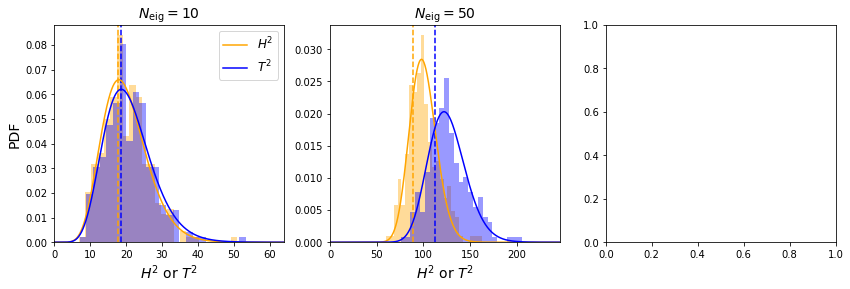

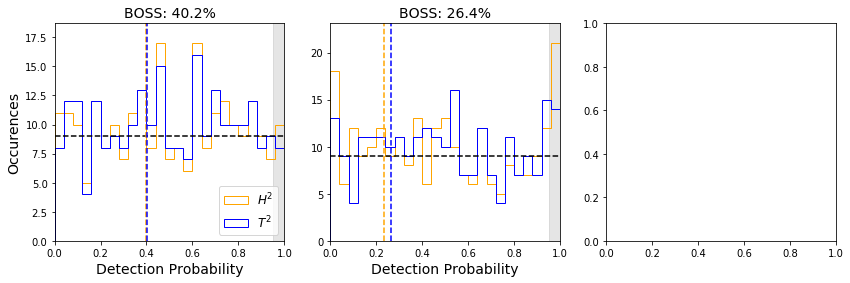

In [18]:
fig1,ax1 = plt.subplots(1,3,figsize=(14,4))
fig2,ax2 = plt.subplots(1,3,figsize=(14,4))

for nn,N_eig in enumerate([10,50]):#,100]):
    print("\n\nN_eig = %d"%N_eig)
    
    # Project data and mocks
    projected_fourpcfN = project_data(filt_flat_fourpcfN,N_eig,'ngc')
    projected_fourpcfS = project_data(filt_flat_fourpcfS,N_eig,'sgc')
    projected_fourpcf_bossN = project_data(filt_flat_fourpcf_bossN,N_eig,'ngc')
    projected_fourpcf_bossS = project_data(filt_flat_fourpcf_bossS,N_eig,'sgc')
    
    # Also project theory model (which is just zeros)
    projected_theoryN = project_data(np.zeros_like(filt_flat_fourpcf_bossN),N_eig,'ngc')
    projected_theoryS = project_data(np.zeros_like(filt_flat_fourpcf_bossS),N_eig,'sgc')

    ### Compute distribution of mock data using sets of (N-1) mocks
    this_n_mocks = len(projected_fourpcfN)-1

    all_T2, all_H2 = [],[]
    for i in range(len(projected_fourpcfN)):

        # Define data
        projected_mockN = projected_fourpcfN[i]
        projected_mockS = projected_fourpcfS[i]

        # Define sample covariance in projected space
        projected_covN = np.cov(projected_fourpcfN[np.arange(len(projected_fourpcfN))!=i].T)
        projected_covS = np.cov(projected_fourpcfS[np.arange(len(projected_fourpcfS))!=i].T)
        
        inv_projected_covN = np.linalg.inv(projected_covN)
        inv_projected_covS = np.linalg.inv(projected_covS)

        T2_statistic = np.inner(projected_mockN-projected_theoryN,np.inner(inv_projected_covN,projected_mockN-projected_theoryN))
        T2_statistic += np.inner(projected_mockS-projected_theoryS,np.inner(inv_projected_covS,projected_mockS-projected_theoryS))
        
        all_T2.append(T2_statistic)
        
    all_T2 = np.asarray(all_T2)
    
    # Compute also Hartlap-rescaled statistic
    hartlap_factor = (this_n_mocks-N_eig-2.)/(this_n_mocks-1)
    print("Hartlap Factor for Bootstrapped PDF: %.3f"%hartlap_factor)
    all_H2 = all_T2*hartlap_factor
    
    ### Compute T2 and H2 statistics on BOSS data using all N_mocks mocks
    projected_covN = np.cov(projected_fourpcfN.T)
    projected_covS = np.cov(projected_fourpcfS.T)
    inv_projected_covN = np.linalg.inv(projected_covN)
    inv_projected_covS = np.linalg.inv(projected_covS)
    T2_boss = np.inner(projected_fourpcf_bossN-projected_theoryN,np.inner(inv_projected_covN,projected_fourpcf_bossN-projected_theoryN))
    T2_boss += np.inner(projected_fourpcf_bossS-projected_theoryS,np.inner(inv_projected_covS,projected_fourpcf_bossS-projected_theoryS))
    hartlap_factor = (n_mocks-N_eig-2.)/(n_mocks-1)
    print("Hartlap Factor for BOSS: %.3f"%hartlap_factor)
    H2_boss = T2_boss*hartlap_factor
    
    ### Compute PDFs and CDFs (easiest to do CDFs numerically with a fine grid)
    mmax = max(all_T2)*1.2
    x_arr = np.linspace(0.001,mmax,1000)
    p = N_eig
    n = n_mocks-1
    chi2_single_pdf = chi2.pdf(x_arr,p)
    T2_single_pdf = np.exp((p/2.-1.)*np.log(x_arr)-p/2.*np.log(n)-0.5*(n+1.)*np.log(x_arr/n+1.))*gamma_fn((n+1.)/2.)/(gamma_fn(p/2.)*gamma_fn((n-p+1.)/2.))

    # Compute PDF of H^2_NGC + H^2_SGC using a convolution
    chi2_pdf = np.fft.ifft(np.fft.fft(chi2_single_pdf)**2.).real
    chi2_pdf /= np.sum(chi2_pdf)*np.diff(x_arr)[0]
    
    # Compute PDF of T^2_NGC + T^2_SGC using a convolution
    T2_pdf = np.fft.ifft(np.fft.fft(T2_single_pdf)**2.).real
    T2_pdf /= np.sum(T2_pdf)*np.diff(x_arr)[0]
    
    # Compute CDFs
    chi2_cdf = interp1d(x_arr,np.cumsum(chi2_pdf)*np.diff(x_arr)[0])
    T2_cdf = interp1d(x_arr,np.cumsum(T2_pdf)*np.diff(x_arr)[0])

    ### Plot distributions
    # Ideally: T^2 statistic should follow the T^2 curve, whilst H^2 statistic is slightly more peaked than the chi^2 curve 

    bins = 25
    #plt.figure()
    ct,_,_=ax1[nn].hist(all_H2,bins=bins,alpha=0.4,density=1,color='orange')#,label=r'$H^2$')
    ax1[nn].hist(all_T2,bins=bins,alpha=0.4,density=1,color='blue')#,label=r'$T^2$');
    ax1[nn].vlines(T2_boss,0,2*mmax,color='blue',linestyles='--')
    ax1[nn].vlines(H2_boss,0,2*mmax,color='orange',linestyles='--')
    ax1[nn].plot(x_arr,chi2_pdf,color='orange',label=r'$H^2$')
    ax1[nn].plot(x_arr,T2_pdf,color='blue',label=r'$T^2$')
    if nn==0:
        ax1[nn].legend(fontsize=12);
    ax1[nn].set_xlim([0,mmax])
    ax1[nn].set_ylim([0,max([max(ct),max(chi2_pdf)])*1.05])
    ax1[nn].set_xlabel(r'$H^2$ or $T^2$',fontsize=14)
    if nn==0: ax1[nn].set_ylabel(r'PDF',fontsize=14)
    ax1[nn].set_title(r'$N_\mathrm{eig} = %d$'%N_eig,fontsize=14);
    if nn==2: fig1.savefig(plot_dir+'projected_pdfs_all.pdf',bbox_inches='tight')

    ### Compute detection probabilities, as a 1-tail test
    prob_T2 = T2_cdf(all_T2)
    prob_chi2 = chi2_cdf(all_H2)

    prob_T2_boss = T2_cdf(T2_boss)
    prob_chi2_boss = chi2_cdf(H2_boss)

    # Count fraction of false detections 
    N_detections_T2 = (np.sum(prob_T2>0.95))*1./n_mocks
    N_detections_chi2 = (np.sum(prob_chi2>0.95))*1./n_mocks

    print("\nFraction of 2-sigma false 'detections' with %d eigenvalues"%N_eig)
    print("chi^2 + Hartlap model: %.3f"%N_detections_chi2)
    print("T^2: %.3f"%N_detections_T2)
    print("Expected: %.3f"%(0.05))

    print("\nBOSS Detection Rates:")
    print("chi^2 + Hartlap model: %.3f"%prob_chi2_boss)
    print("T^2: %.3f"%prob_T2_boss)

    ### Histogram the detection PDFs
    #plt.figure()
    ax2[nn].set_title(r'BOSS: %.1f%%'%(100.*prob_T2_boss),fontsize=14)
    ct,_,_=ax2[nn].hist(prob_chi2,bins=bins,histtype='step',color='orange',label=r'$H^2$',density=0,range=[0,1]);
    ax2[nn].hist(prob_T2,bins=bins,histtype='step',color='blue',label=r'$T^2$',density=0,range=[0,1]);
    ax2[nn].hlines(n_mocks/bins,0,1,linestyles='--')
    ax2[nn].vlines(prob_chi2_boss,0,max(ct)*1.2,color='orange',linestyles='--')
    ax2[nn].vlines(prob_T2_boss,0,max(ct)*1.2,color='blue',linestyles='--')
    ax2[nn].set_xlim([0.0,1])
    ax2[nn].fill_betweenx(np.arange(0,max(ct)*2),0.95,1,alpha=0.1,color='k')
    ax2[nn].set_ylim([0,max(ct)*1.1])
    if nn==0: ax2[nn].legend(fontsize=12,loc='lower right');
    if nn==0: ax2[nn].set_ylabel(r'Occurences',fontsize=14)
    ax2[nn].set_xlabel(r'Detection Probability',fontsize=14);
    if nn==2:
        fig2.savefig(plot_dir+'projected_cdfs_all.pdf',bbox_inches='tight')

Text(0,0.5,'PDF')

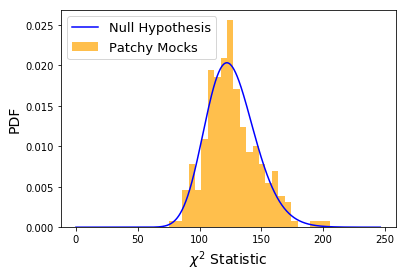

In [26]:
bins = 25
#plt.figure()
#ct,_,_=plt.hist(all_H2,bins=bins,alpha=0.4,density=1,color='orange')#,label=r'$H^2$')
plt.hist(all_T2,bins=bins,alpha=0.7,density=1,color='orange',label=r'Patchy Mocks');
#plt.vlines(T2_boss,0,2*mmax,color='red',linestyles='--',label='BOSS CMASS')
#plt.vlines(H2_boss,0,2*mmax,color='orange',linestyles='--')
#plt.plot(x_arr,chi2_pdf,color='orange',label=r'$H^2$')
plt.plot(x_arr,T2_pdf,color='blue',label=r'Null Hypothesis')
# if nn==0:
plt.legend(fontsize=13,loc='upper left');
#plt.xlim([0,mmax])
#plt.ylim([0,max([max(ct),max(T2_pdf)])*1.05])
plt.xlabel(r'$\chi^2$ Statistic',fontsize=14)
plt.ylabel(r'PDF',fontsize=14)
#plt.title(r'$N_\mathrm{eig} = %d$'%N_eig,fontsize=14);

### This completes the analysis